In [14]:
import numpy as np
import pandas as pd
import sys
import json
import glob


import numpy as np
from matplotlib import pyplot as pl, colors
from PIL import Image, ImageDraw
from matplotlib import rcParams
Image.MAX_IMAGE_PIXELS = 3007724353 #otherwise there will be error for high resolution image reading
import os
import sys
import cv2 as cv

# load the pre-processed dataset
#data_set = 'SC2200108BR6526'
#data_set = 'SC2200109BR6526'
#data_set = 'SC2200110BR7212'
label = '1'
data_set = 'breast_cancer_sample1_rep'+label
#STDir="/projects/activities/deepspace/team/elaheh/data/ST/endometrium/SC2200235_EuE-31"#SC2200236_EuE-31
STDir="/projects/li-lab/Yue/DataPool/Spatial/Xenium/"+data_set#SC2200236_EuE-31

#ndpiDir="/projects/activities/deepspace/team/elaheh/data/ST/endometrium/hover/033122_FFPE_GEX_ENDO_SN_V11U23-282.ndpi"
#ndpiDir="/projects/compsci/jgeorge/USERS/somara/datasets/pdac/021722 FFPE GEX PDAC SN V11A20-355.ndpi"
#ndpiDir= STDir + '/outs/morphology.ome.tif'
#ndpiDir= STDir + '/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif'
#ndpiDir= STDir + '/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
ndpiDir= STDir + '/he_aligned_rep'+label+'.png'
#ndpiDir= STDir + '/Xenium_V1_FFPE_Human_Breast_IDC_With_Addon_he_image.ome.tif'

ResultsDir="/projects/activities/deepspace/team/yue/results"
coords_csv = STDir+"/outs/cell_boundaries.csv.gz"

In [15]:
import scanpy as sc
adata = sc.read_10x_h5(
    filename=STDir+"/outs/cell_feature_matrix.h5"
)

In [16]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    var: 'gene_ids', 'feature_types', 'genome'

In [17]:
df = pd.read_csv(
    STDir+"/outs/cells.csv.gz"
)
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()

In [18]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [19]:
df.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
1,1,847.259912,326.191365,28,1,0,29,58.387031,26.642187
2,2,826.341995,328.031830,94,0,0,94,197.016719,42.130781
3,3,848.766919,331.743187,9,0,0,9,16.256250,12.688906
4,4,824.228409,334.252643,11,0,0,11,42.311406,10.069844
5,5,841.357538,332.242505,48,0,0,48,107.652500,37.479687


In [20]:
scaleFactor_json=json.load(open(STDir+"/outs/experiment.xenium"))


In [21]:
adata.obs.cell_id

1              1
2              2
3              3
4              4
5              5
           ...  
167776    167776
167777    167777
167778    167778
167779    167779
167780    167780
Name: cell_id, Length: 167780, dtype: int64

In [22]:
scaleFactor_json['pixel_size']

0.2125

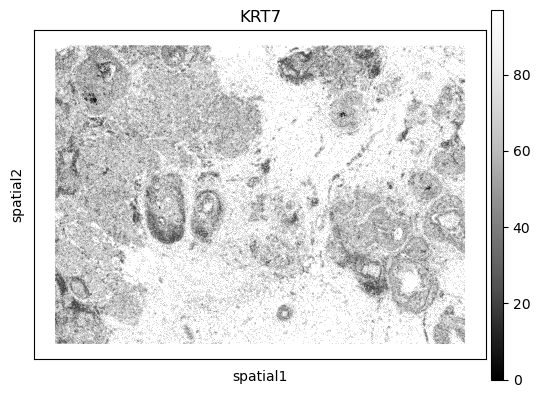

[<AxesSubplot: title={'center': 'KRT7'}, xlabel='spatial1', ylabel='spatial2'>]

In [23]:
sc.pl.spatial(adata, img_key = "hires", color='KRT7',
              size=2, 
              spot_size = 4, 
              #scale_factor = 1,
              #crop_coord=[0, img_shape[1], 0, img_shape[0]],
              #crop_coord=[0, 1000, 0, 1000],
              #title = 'TAVAC',
              #add_outline = True,
              #vmin = 0.8,vmax = 1,
              na_in_legend = False,
              return_fig = True,
              #ax = axs[0],
              #show = False,
              color_map = 'Greys_r'
              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf',
              #colorbar_loc = 'bottom'
             )


In [30]:


def extract_voxel_img_xenium(
    adata,
    ndpiDir,
    rep,
    circle_radius = 90
    
):
    from PIL import Image
    sys.path.insert(1,"/projects/li-lab/Yue/SpatialAnalysis/py/TO_Analysis/utils")
    #import MiscFunctions as misc2
    #img = misc2.tifffile_to_dask(ndpiDir)
    from numpy import moveaxis
    
    img = Image.open(ndpiDir).convert('RGB')
    
    if ndpiDir == '/projects/li-lab/Yue/DataPool/Spatial/Xenium/breast_cancer_sample1_rep1/cell_type_map.png':
        img = img.transpose(method=Image.FLIP_TOP_BOTTOM).resize((35411, 25779)) ##vertical flip he image due to coords issue
    img_data = np.asarray(img)
    print(img_data.shape)    
    #img_data = moveaxis(img_data, 0, 2) ###only for ome.tiff
    #print(img_data.shape)
    
    
    coords = adata.obs[["x_centroid", "y_centroid"]]/scaleFactor_json['pixel_size']

    
    fig = pl.figure()
    ax = fig.add_subplot()

    #     scatter = (
    #         partial(ax.scatter, s=circle_radius, plotnonfinite=True)
    #         if scale_factor is None

    #         else partial(
    #             circles, s=size, ax=ax, scale_factor=scale_factor
    #         )  # size in circles is radius

    #     )

    #fluo data: original is GRB, switch order to RGB #reverse columns RGB-> BGR [:,:,::-1]
    #but hne data use original color 
    #sys.exit()
    #visualize circles
    if rep == 'breast_cancer_sample1_rep2':
        coords = coords.loc[coords.iloc[:, 1] < 19000,:]

    circle_radius_vs = 0.5 #/8 for test on lowest res

    cax = ax.scatter(
                coords.iloc[:, 0],
                coords.iloc[:, 1],
                marker="o",
                s = circle_radius_vs**2,
                facecolors='none', 
                edgecolors='black',
                alpha = 0.2
    )
    #ax.set_xlim(0, max_coord)
    #ax.set_ylim(max_coord, 0)
    ax.autoscale_view()
    fig.tight_layout()
    #pl.axis('off')
    pl.margins(0,0)
    #ax.imshow(img[:,:,[0,1,2]], extent=[0, max_coord, max_coord, 0]) 
    ax.imshow(img_data[:,:,[0,1,2]])
    
        
    data_dir = '/projects/activities/deepspace/team/yue/data/Xenium-data/'
    data_set = rep
    if not os.path.exists(data_dir+rep+'/'):
        os.mkdir(data_dir+rep+'/')
    
    
    
    #circle_radius = rcParams['lines.markersize'] ** 2
    img = Image.fromarray(img_data, 'RGB')
    width, height = img.size
    
    print(img.size)
    #circle_radius = 2*55/6500*width ##original full image 6.5mm, spot radius 55um
    
    
    for idx in range(coords.shape[0]):
        ctr = (coords.iloc[idx, 0], coords.iloc[idx, 1])
        
        
        img_cropped = img.crop((ctr[0]-circle_radius, ctr[1]-circle_radius, ctr[0]+circle_radius, ctr[1]+circle_radius))

        mask = Image.new('L', img_cropped.size)
        mask_draw = ImageDraw.Draw(mask)
        w, h = img_cropped.size
        mask_draw.ellipse((0, 0, w, h), fill=255)
        #mask.show()

        # add mask as alpha channel
        img_cropped.putalpha(mask)

    # save as png which keeps alpha channel 
    

        #img_cropped.show()
        
        if not os.path.exists(data_dir+data_set+'/voxel_pics_'+str(circle_radius)+'/'):
            os.mkdir(data_dir+data_set+'/voxel_pics_'+str(circle_radius)+'/')
            
        img_cropped.save(data_dir+data_set+'/voxel_pics_'+str(circle_radius)+'/'+str(adata.obs.cell_id[idx])+'.png', subsampling=0)
        #break
        
    adata.to_df().to_csv(data_dir+data_set+'/spatial_rna.csv')

    
    
    

(25779, 35411, 3)
(35411, 25779)


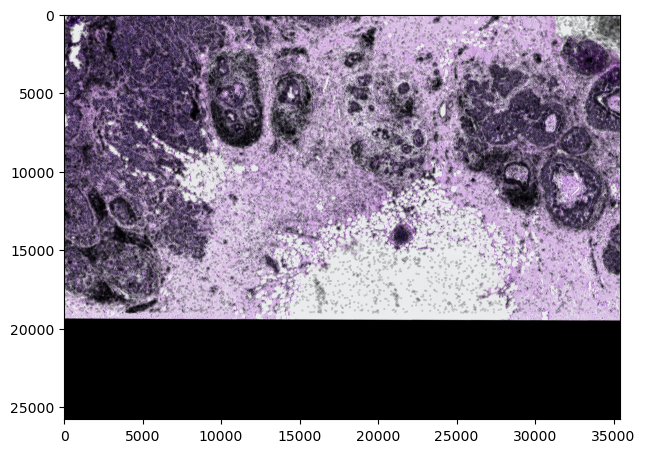

In [14]:
ndpiDir= STDir + '/he_aligned_rep'+label+'.png'

extract_voxel_img_xenium(
    adata,
    ndpiDir,
    data_set,
    circle_radius = 128
)

In [30]:
ndpiDir

'/projects/li-lab/Yue/DataPool/Spatial/Xenium/breast_cancer_sample1_rep1/he_aligned_rep1.png'

/tmp/ipykernel_147472/87014215.py:17: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  img = img.transpose(method=Image.FLIP_TOP_BOTTOM).resize((35411, 25779)) ##vertical flip he image due to coords issue


(25779, 35411, 3)
(35411, 25779)


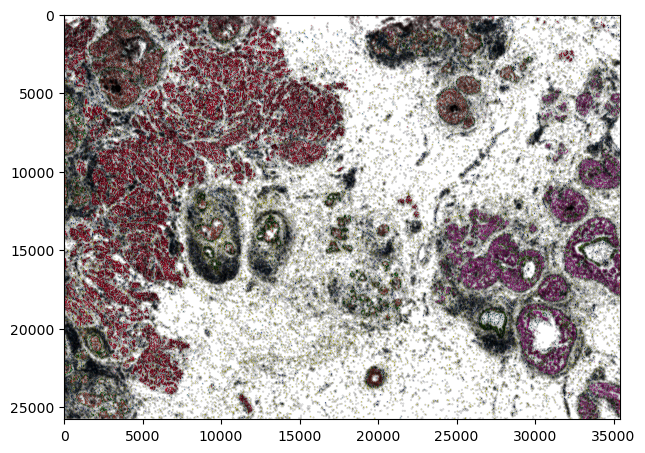

In [31]:
ndpiDir= STDir + '/cell_type_map.png'

extract_voxel_img_xenium(
    adata,
    ndpiDir,
    data_set+'_cell_type',
    circle_radius = 128
)

In [29]:
ndpiDir

'/projects/li-lab/Yue/DataPool/Spatial/Xenium/breast_cancer_sample1_rep1/cell_type_map.png'

In [ ]:
??moveaxis

# Align image with transform matrix

In [8]:
data_set = 'breast_cancer_sample1_rep'+label
#STDir="/projects/activities/deepspace/team/elaheh/data/ST/endometrium/SC2200235_EuE-31"#SC2200236_EuE-31
STDir="/projects/li-lab/Yue/DataPool/Spatial/Xenium/"+data_set#SC2200236_EuE-31


#coordinate_transform = pd.read_csv(STDir+"/Xenium_FFPE_Human_Breast_Cancer_Rep"+label+"_he_imagealignment.csv", header = None)
coordinate_transform = pd.read_csv(STDir+"/he_align_rep"+label+"_matrix.csv", header = None)

coordinate_transform = coordinate_transform.values

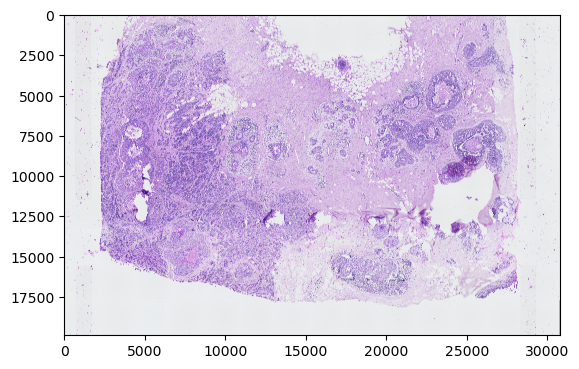

In [9]:
from PIL import Image
sys.path.insert(1,"/projects/li-lab/Yue/SpatialAnalysis/py/TO_Analysis/utils")
#import MiscFunctions as misc2
#img = misc2.tifffile_to_dask(ndpiDir)
ndpiDir= STDir + '/Xenium_FFPE_Human_Breast_Cancer_Rep'+label+'_he_image.ome.tif'


img = Image.open(ndpiDir)
pl.imshow(img)
# from numpy import moveaxis

# #
# img_data = np.array(img)
# print(img_data.shape)    
# img_data = moveaxis(img_data, 0, 2)
# print(img_data.shape)

In [10]:
from pathlib import Path

#path_to_visium_bundle = Path("~/xenium-publication/visium/").expanduser()
path_to_xenium_bundle = Path(STDir+"/outs").expanduser()
path_to_xenium_celltype_labels = Path(STDir+"/outs/cell_groups_rep"+label+".csv").expanduser()

In [11]:
sys.path.insert(1, '/projects/li-lab/Yue/SpatialAnalysis/py/XeniumExperiments/janesick_nature_comms_2023_companion/') ##~wont work, has to start with /Users

import json
from collections import namedtuple, Counter

import numpy as np
import scanpy as sc
import pandas as pd

## Image manipulation and geometry
from tifffile import imread
from skimage.io import imread as skimread

## Plotting imports
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_hex, Colormap
from matplotlib.cm import ScalarMappable

### Functions for registration of Xenium to Visium data and associated analyis and visualization
## Visualization functions
from companion_functions import (
    hexlist_to_cmap,
    polygons_coords_to_patch_collection,
    plot_polygons,
    hex_corner_offset,
    polygon_corners,
    celltypes,
    celltypes,
    hex_codes,
    ctype_to_code_map,
    ctype_hex_map,
    ctype_cmap,
)

## Analysis functions
from companion_functions import (
    unique_encode,
    get_xenium_to_morphology_transform_from_xenium_morphology_image,
    get_xenium_capture_polygon_um,
    transform_coordinates,
    get_median_spot_to_spot_distance_from_centroids,
    generate_space_filling_visium_polygons,
    get_visium_capture_polygon,
    __OUTSIDE_VISIUM_CAPTURE_AREA_BARCODE__,
    bin_xenium_data_to_visium_spots,
    generate_anndata_matrix_from_transcript_assignments,
)

In [12]:
## Read in Xenium transcript data and decode the bytes column to string
xenium_transcripts = pd.read_parquet(path_to_xenium_bundle / "transcripts.parquet")
xenium_transcripts.feature_name = xenium_transcripts.feature_name.str.decode("utf-8")

## Read in the Xenium cell positions and cell metadata.
xenium_cell_info = pd.read_csv(path_to_xenium_bundle / "cells.csv.gz").set_index(
    "cell_id"
)

## Read in the Xenium morphology (DAPI) MIP image. Note: We are reading the image at the resolution of
## the third pyramid level: full_resolution / 2 ** 3. We are using this image for plotting.
## The Xenium imaging area is large, and the full resolution image is large enough to be slow to plot.
## Working with a lower resolution image when possible is a convenience.
pyramid_level = 0
xenium_morphology_mip_at_pyramid_level = imread(
    path_to_xenium_bundle / "morphology_mip.ome.tif", series=0, level=pyramid_level
)

## Read in the nucleus boundary polygon information. Xenium polygons are a plotting convenience and should not
## be used for analysis. A nucleus mask is provided for analysis of Xenium segmentation.
xenium_nucleous_boundaries_df = pd.read_parquet(
    path_to_xenium_bundle / "nucleus_boundaries.parquet"
)

## Transformation matrix to transform from the Xenium coordinate system to the morphology image coordinate system
## at pyramid level. Determined using the pixel size of the morphology image. 
xenium_to_morphology_at_pyramid_transformation = (
    get_xenium_to_morphology_transform_from_xenium_morphology_image(
        path_to_xenium_bundle / "morphology_mip.ome.tif", pyramid_level
    )
)

## Cell type assignments as determined by label transfer from a matched FLEX dataset.
## This is a supplemental file provided within the publication.
## barcode X celltype
xenium_celltype_df = pd.read_csv(path_to_xenium_celltype_labels).set_index("Barcode")

In [13]:
# ## Transformation matrix exported from Xenium Explorer
xenium_morphology_to_visium_full_res_transformation = np.array(
    [
        [1.87594468e-02, -4.07641677e-01, 1.63476055e04],
        [3.91300071e-01, 1.26819551e-02, 4.12499099e03],
        [-8.39854141e-08, -9.91112632e-07, 1.03706895e00],
    ]
)

#coordinate_transform = pd.read_csv(STDir+"/Xenium_FFPE_Human_Breast_Cancer_Rep"+label+"_he_imagealignment.csv", header = None)
coordinate_transform = pd.read_csv(STDir+"/he_align_rep"+label+"_matrix.csv", header = None)

he_to_xenium_full_res_transformation = coordinate_transform.values

## Transformation matrix between Xenium full resolution (DAPI) morphology image and the Xenium coordinate system.
xenium_to_morphology_transformation = (
    get_xenium_to_morphology_transform_from_xenium_morphology_image(
        path_to_xenium_bundle / "morphology_mip.ome.tif", 0
    )
)

## Xenium coordinates must be transformed into image coordinates before being transformed into Visium image coordinates.
## The following describes that combined transformation (a matrix multiplication of the two transformation matrices).
xenium_to_visium_full_res_transformation = (
    xenium_morphology_to_visium_full_res_transformation
    @ xenium_to_morphology_transformation
)

he_to_visium_full_res_transformation = (
    he_to_xenium_full_res_transformation
    @ xenium_to_morphology_transformation 

)

In [14]:
img_array = np.array(img)
coordinate_transform = he_to_xenium_full_res_transformation
shape = coordinate_transform.shape
assert len(shape) == 2, "Expected coordinate transform to be 2D."
assert (
    shape[0] == 3 and shape[1] == 3
), f"Invalid coordinate transform shape. Expected (3,3), found {shape}"
warp = coordinate_transform[:2, :]
mask = cv.warpAffine(
    img_array,
    warp,
    (xenium_morphology_mip_at_pyramid_level.shape[1], xenium_morphology_mip_at_pyramid_level.shape[0]), ##extract from rep1 meta data of dapi image
    flags=cv.INTER_NEAREST,
).astype(np.uint32)

In [15]:
mask.shape

(25779, 35411, 3)

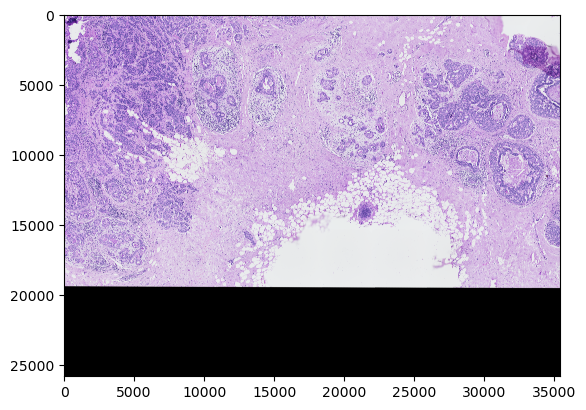

In [16]:
fig = pl.figure()
ax = fig.add_subplot()
#ax.set_axis_off()

pl.imshow(mask)

In [17]:
xenium_morphology_mip_at_pyramid_level.shape

(25779, 35411)

In [18]:
from PIL import Image
mask = np.array(mask, dtype=np.uint8)
img = Image.fromarray(mask, 'RGB')

In [19]:
np.sqrt(500)*np.sqrt(mask.shape[0]*mask.shape[1]/41118594.1)

105.35811757598756

In [20]:
img.save(STDir + '/he_aligned_rep'+label+'.png') ##maintain pixel dimension

In [ ]:
np.sqrt(mask.shape[0]*mask.shape[1]/41118594.1)

In [ ]:
# code_dir = '/projects/li-lab/Yue/SpatialAnalysis/'

# gene_intersect_df = pd.read_csv(code_dir+'py/XeniumExperiments/xenium_genes_intersection.csv', index_col = 0)
# gene_intersect = gene_intersect_df['0']
# gene_intersect

In [ ]:
# pd.DataFrame(adata.to_df().columns).to_csv(code_dir+'py/XeniumExperiments/xenium_genes_intersection.csv')

In [ ]:
rcParams['lines.markersize'] ** 2